<a href="https://colab.research.google.com/github/Prateeks16/Crop_recommedation_API/blob/main/crop_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
df = pd.read_csv("/content/Crop_recommendation.csv")
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


Dataset shape: (2200, 8)

Columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
Training samples: 1760
Test samples: 440

Decision Tree Accuracy: 0.9795
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.80      0.89        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      0.95      0.95        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.86      0.90      0.88        20
       maize       0.95      1.00      0.98        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.86      0.95      0.90        20
    mungbea

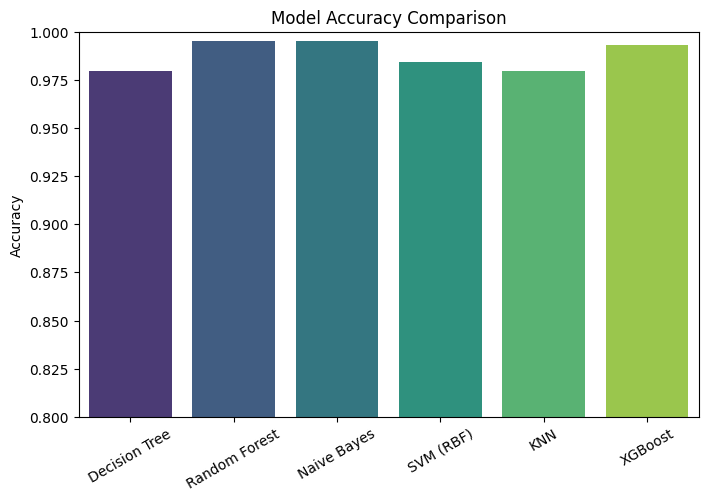

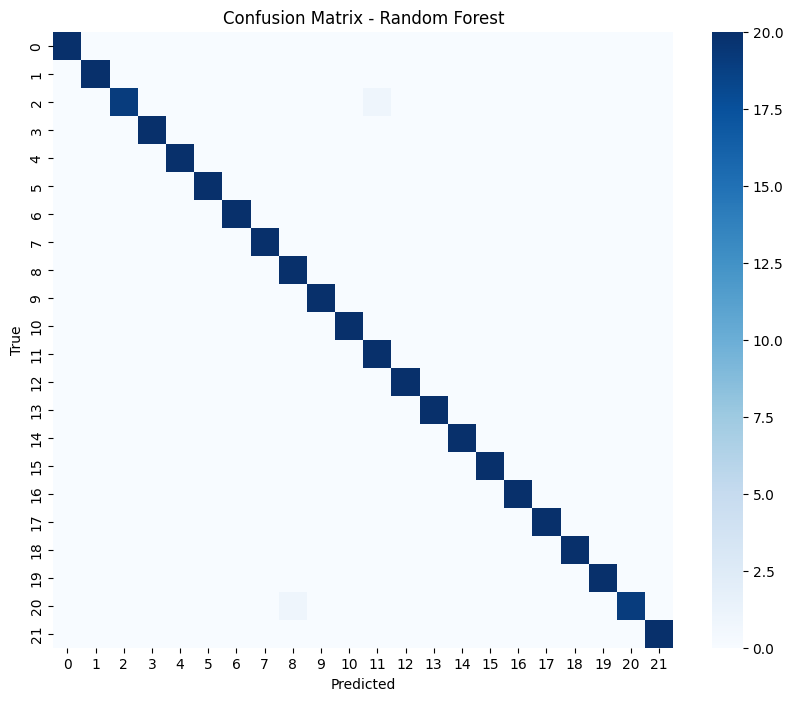

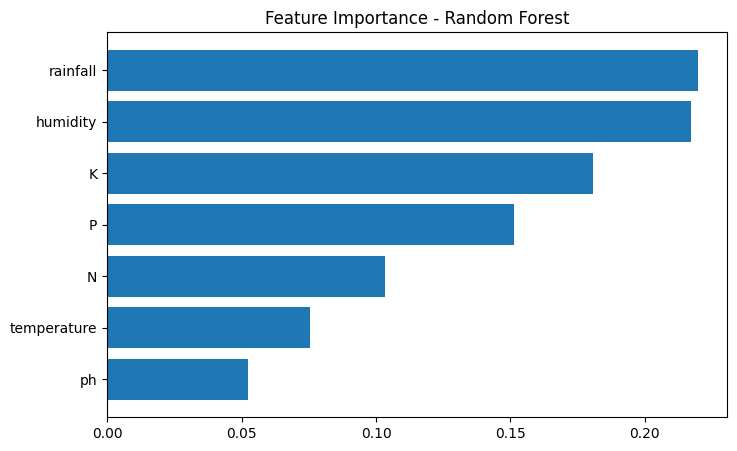


🌱 Recommended Crop for given conditions: rice


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv("/content/Crop_recommendation.csv")

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()


X = df.drop("label", axis=1)
y = df["label"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))


plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=30)
plt.show()

best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feature_names = X.columns
    sorted_idx = np.argsort(importances)

    plt.figure(figsize=(8,5))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], align="center")
    plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
    plt.title(f"Feature Importance - {best_model_name}")
    plt.show()


sample = np.array([[90, 42, 43, 20.5, 82.0, 6.5, 200]])
sample_scaled = scaler.transform(sample)
prediction = best_model.predict(sample_scaled)
predicted_crop = le.inverse_transform(prediction)[0]

print(f"\n🌱 Recommended Crop for given conditions: {predicted_crop}")



Decision Tree (with noise) Accuracy: 0.8523

Random Forest (with noise) Accuracy: 0.9227

Naive Bayes (with noise) Accuracy: 0.9364

SVM (RBF) (with noise) Accuracy: 0.9341

KNN (with noise) Accuracy: 0.9273

XGBoost (with noise) Accuracy: 0.9159

=== Robustness Comparison ===
               Clean Data  Noisy Data  Accuracy Drop
SVM (RBF)        0.984091    0.934091       0.050000
KNN              0.979545    0.927273       0.052273
Naive Bayes      0.995455    0.936364       0.059091
Random Forest    0.995455    0.922727       0.072727
XGBoost          0.993182    0.915909       0.077273
Decision Tree    0.979545    0.852273       0.127273


<Figure size 1000x600 with 0 Axes>

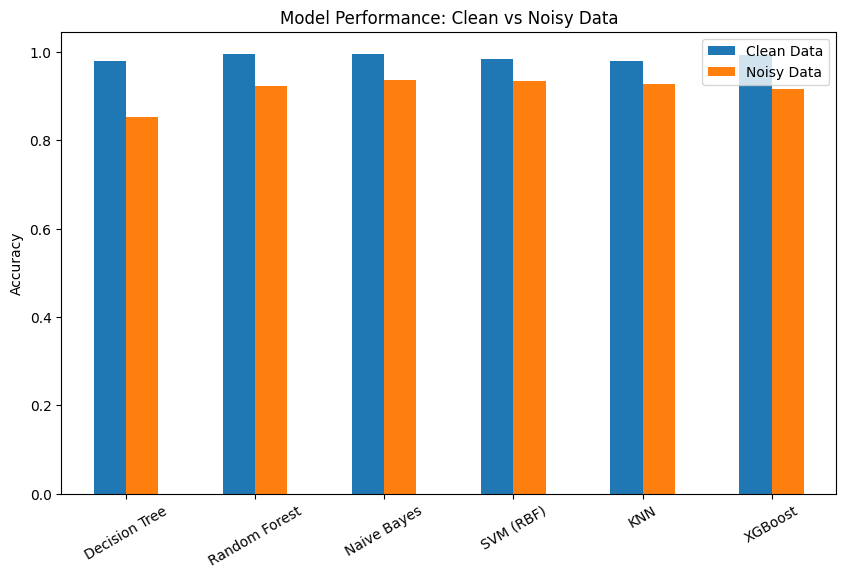

In [3]:

def add_noise(X, noise_level=0.05):
    noisy_X = X.copy()

    for col in range(noisy_X.shape[1]):
        noise = np.random.normal(0, noise_level * np.std(noisy_X[:, col]), noisy_X.shape[0])
        noisy_X[:, col] += noise
    return noisy_X


def flip_labels(y, flip_fraction=0.05):
    y_noisy = y.copy()
    n_flip = int(len(y) * flip_fraction)
    flip_indices = np.random.choice(len(y), n_flip, replace=False)
    random_labels = np.random.choice(np.unique(y), n_flip)
    y_noisy[flip_indices] = random_labels
    return y_noisy

X_noisy = add_noise(X_scaled, noise_level=0.1)
y_noisy = flip_labels(y_encoded, flip_fraction=0.05)

Xn_train, Xn_test, yn_train, yn_test = train_test_split(
    X_noisy, y_noisy, test_size=0.2, random_state=42, stratify=y_noisy
)

noisy_results = {}

for name, model in models.items():
    model.fit(Xn_train, yn_train)
    y_pred = model.predict(Xn_test)
    acc = accuracy_score(yn_test, y_pred)
    noisy_results[name] = acc
    print(f"\n{name} (with noise) Accuracy: {acc:.4f}")


comparison_df = pd.DataFrame({
    "Clean Data": results,
    "Noisy Data": noisy_results
})

comparison_df["Accuracy Drop"] = comparison_df["Clean Data"] - comparison_df["Noisy Data"]
print("\n=== Robustness Comparison ===")
print(comparison_df.sort_values("Accuracy Drop"))

plt.figure(figsize=(10,6))
comparison_df[["Clean Data","Noisy Data"]].plot(kind="bar", figsize=(10,6))
plt.title("Model Performance: Clean vs Noisy Data")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.show()


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1322 - loss: 2.9842 - val_accuracy: 0.5364 - val_loss: 2.1587
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4681 - loss: 1.9415 - val_accuracy: 0.7341 - val_loss: 0.9579
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6667 - loss: 1.0483 - val_accuracy: 0.7864 - val_loss: 0.5751
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7135 - loss: 0.7584 - val_accuracy: 0.8932 - val_loss: 0.3841
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7655 - loss: 0.6417 - val_accuracy: 0.8705 - val_loss: 0.3501
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8127 - loss: 0.5186 - val_accuracy: 0.9432 - val_loss: 0.2385
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8139 - loss: 0.4887 - val_accuracy: 0.9386 - val_loss: 0.2268
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8463 - loss: 0.3970 - val_accuracy: 0.9295 - val_los

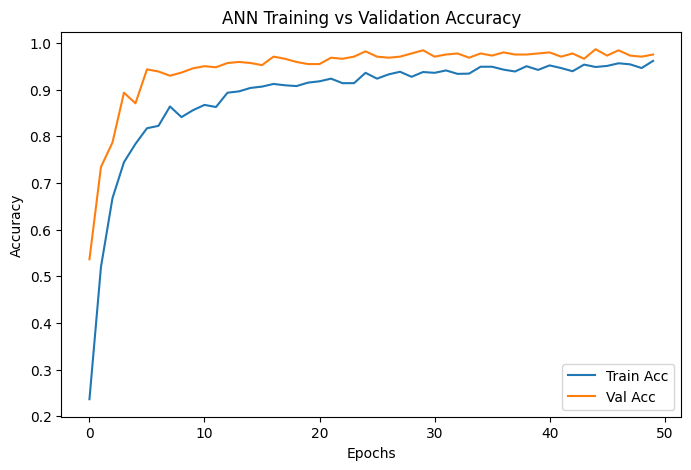

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
🌱 ANN Recommended Crop: rice


In [4]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y_encoded))
y_cat = to_categorical(y_encoded, num_classes)

Xa_train, Xa_test, ya_train, ya_test = train_test_split(
    X_scaled, y_cat, test_size=0.2, random_state=42, stratify=y_encoded
)

ann_model = Sequential([
    Dense(64, input_dim=X_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])


ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = ann_model.fit(
    Xa_train, ya_train,
    epochs=50,
    batch_size=32,
    validation_data=(Xa_test, ya_test),
    verbose=1
)


ann_loss, ann_acc = ann_model.evaluate(Xa_test, ya_test, verbose=0)
print(f"\nANN Test Accuracy: {ann_acc:.4f}")

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("ANN Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

sample = np.array([[90, 42, 43, 20.5, 82.0, 6.5, 200]])
sample_scaled = scaler.transform(sample)
ann_pred = ann_model.predict(sample_scaled)
predicted_crop = le.inverse_transform([np.argmax(ann_pred)])[0]

print(f"🌱 ANN Recommended Crop: {predicted_crop}")


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1503 - loss: 2.9359 - val_accuracy: 0.5750 - val_loss: 2.1944
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4600 - loss: 2.0600 - val_accuracy: 0.7182 - val_loss: 1.2026
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6404 - loss: 1.3126 - val_accuracy: 0.7568 - val_loss: 0.8710
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6816 - loss: 1.1288 - val_accuracy: 0.8636 - val_loss: 0.7368
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7346 - loss: 1.0359 - val_accuracy: 0.8500 - val_loss: 0.6932
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7651 - loss: 0.9070 - val_accuracy: 0.9068 - val_loss: 0.6485
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7880 - loss: 0.8303 - val_accuracy: 0.8886 - val_loss: 0.6255
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8122 - loss: 0.8654 - val_accuracy: 0.9000 - val_loss

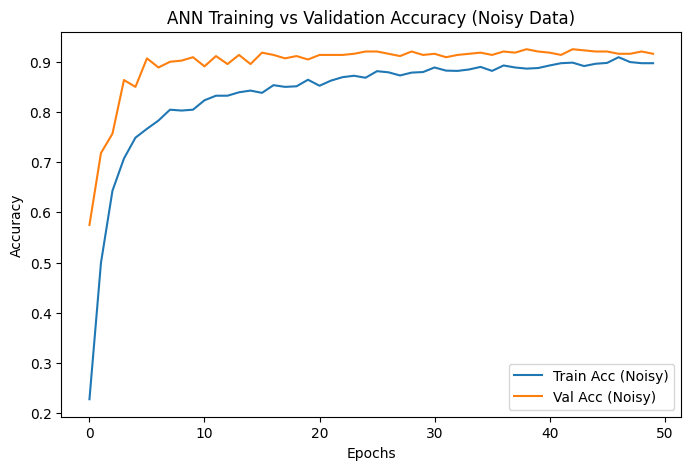

In [5]:

def add_noise(X, noise_level=0.05):
    noisy_X = X.copy()
    for col in range(noisy_X.shape[1]):
        noise = np.random.normal(0, noise_level * np.std(noisy_X[:, col]), noisy_X.shape[0])
        noisy_X[:, col] += noise
    return noisy_X

def flip_labels(y, flip_fraction=0.05):
    y_noisy = y.copy()
    n_flip = int(len(y) * flip_fraction)
    flip_indices = np.random.choice(len(y), n_flip, replace=False)
    random_labels = np.random.choice(np.unique(y), n_flip)
    y_noisy[flip_indices] = random_labels
    return y_noisy

X_ann_noisy = add_noise(X_scaled, noise_level=0.1)   # 10% noise
y_ann_noisy = flip_labels(y_encoded, flip_fraction=0.05)  # 5% label noise

y_ann_noisy_cat = to_categorical(y_ann_noisy, num_classes)

Xn_train, Xn_test, yn_train, yn_test = train_test_split(
    X_ann_noisy, y_ann_noisy_cat, test_size=0.2, random_state=42, stratify=y_ann_noisy
)

ann_noisy = Sequential([
    Dense(64, input_dim=Xn_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])


ann_noisy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_noisy = ann_noisy.fit(
    Xn_train, yn_train,
    epochs=50,
    batch_size=32,
    validation_data=(Xn_test, yn_test),
    verbose=1
)

loss_noisy, acc_noisy = ann_noisy.evaluate(Xn_test, yn_test, verbose=0)
print(f"\nANN Test Accuracy with Noise: {acc_noisy:.4f}")

print(f"ANN Accuracy (Clean Data): {ann_acc:.4f}")
print(f"ANN Accuracy (Noisy Data): {acc_noisy:.4f}")
print(f"Accuracy Drop: {ann_acc - acc_noisy:.4f}")

plt.figure(figsize=(8,5))
plt.plot(history_noisy.history['accuracy'], label='Train Acc (Noisy)')
plt.plot(history_noisy.history['val_accuracy'], label='Val Acc (Noisy)')
plt.title("ANN Training vs Validation Accuracy (Noisy Data)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
